# Bending energy

I have a hypothesis that the active nematics bend more in slower flowing channels, resulting in more free energy penalty. It would be great if I can do a simulation on a constrained system, to see how the orientation field is optimized. However, since the simulation method is not readily available, I'm going to test this hypothesis on experimental data first. The plan is:

- extract orientational field $p$ from images;
- compute bending energy based on $p$ and the boundaries;
- plot bending energy as a function of flow rate (fraction).

In this notebook, I'm going to develop the method for image analysis, based on the code I got from Claire (originally from A. N.-F.'s lab).

## 0 Packages

In [189]:
import os
from skimage import io
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, uniform_filter
import numpy as np
import pandas as pd
from myimagelib.myImageLib import bestcolor, readdata
import time
import matplotlib
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams["xtick.direction"] = "in"
matplotlib.rcParams["ytick.direction"] = "in"
plt.rcParams['xtick.major.size'] = 2  # Length of major ticks
plt.rcParams['ytick.major.size'] = 2  # Length of major ticks
plt.rcParams['xtick.minor.size'] = 1  # Length of minor ticks
plt.rcParams['ytick.minor.size'] = 1  # Length of minor ticks

## 1 Filament orientation

Detect the director field from the images. This section main reproduce the code developed in Matlab by Perry W. Ellis (GaTech). The method is described in [a Nature Physics paper](https://www.nature.com/articles/nphys4276#Sec2). The idea is to measure the pixel intensity fluatuations around each pixel at all directions, and then identify the direction with the least fluctuations as the "coherence direction". This coherent direction is determined as the director at that pixel. 

In [2]:
def fndstruct(sigma1, sigma2, im):
    """
    Returns the structure tensor orientation of an image.

    Args:
    sigma1 -- gaussian filter sigma for the raw image.
    sigma2 -- gaussian filter sigma for the gradient fields.
    im -- the input image, [M x N].

    Returns:
    director -- the director field of the nematic system, [M x N x 2].
    S -- the magnitude of the Q-tensor, [M x N].
    """
    imgf = gaussian_filter(im, sigma1)

    gx, gy = np.gradient(imgf)

    gxgx = gx * gx
    gxgy = gx * gy
    gygy = gy * gy

    gxgx = gaussian_filter(gxgx, sigma2)
    gxgy = gaussian_filter(gxgy, sigma2)
    gygy = gaussian_filter(gygy, sigma2)

    aa = np.array([[gxgx, gxgy], [gxgy, gygy]])
    eigenvalues, eigenvectors = np.linalg.eig(aa.transpose(2, 3, 0, 1).reshape(-1, 2, 2))
    eigenvalues = eigenvalues.reshape(aa.shape[2], aa.shape[3], 2)
    eigenvectors = eigenvectors.reshape(aa.shape[2], aa.shape[3], 2, 2)

    # Find the indices of the smaller eigenvalues
    indices = np.argmax(eigenvalues, axis=2)

    # Extract the corresponding eigenvectors
    director = np.array([eigenvectors[i, j, :, indices[i, j]] for i in range(eigenvectors.shape[0]) for j in range(eigenvectors.shape[1])])
    director = director.reshape(eigenvectors.shape[0], eigenvectors.shape[1], 2)

    # require the y component director to be positive, otherwise flip the director
    director[director[:,:,1]<=0] *= -1

    return director, np.max(eigenvalues, axis=2)

In [3]:
img = io.imread(r"C:\Users\liuzy\Documents\AN\kymo\08_C-2100.tif")

(-0.5, 399.5, 499.5, -0.5)

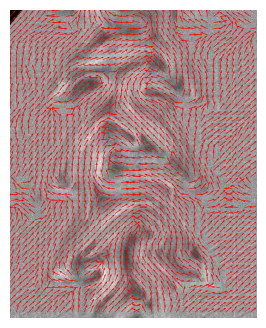

In [7]:
d, s = fndstruct(1, 10, img)
plt.figure(figsize=(4,4), dpi=100)
plt.imshow(img, cmap='gray')
step = 10  # Adjust the step size to make the arrows sparse
Y, X = np.mgrid[0:img.shape[0]:step, 0:img.shape[1]:step]
plt.quiver(X, Y, d[::step, ::step, 0], d[::step, ::step, 1], color='r', scale=30)
plt.axis("off")

## 2 Apply mask

In [42]:
mask = io.imread(r"C:\Users\liuzy\Documents\kymo\mask\A08.tif")

(-0.5, 399.5, 499.5, -0.5)

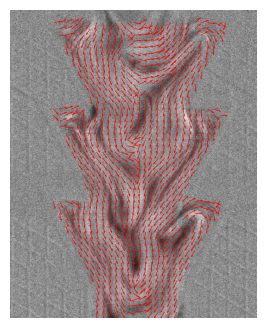

In [63]:
# apply mask to image
d = d.astype(float)
d[~mask.astype("bool"), :] = np.nan
plt.figure(figsize=(4,4), dpi=100)
plt.imshow(img, cmap='gray')
step = 10  # Adjust the step size to make the arrows sparse
Y, X = np.mgrid[0:img.shape[0]:step, 0:img.shape[1]:step]
plt.quiver(X, Y, d[::step, ::step, 0], d[::step, ::step, 1], color='r', scale=30)
plt.axis("off")

## 3 Bending energy

### 3.1 Q-tensor

Based on the director orientations, we can estimate how distorted the filaments are. We first notice that, when we represent the director field using vectors, we lose the head-tail symmetry: vectors pointing forward and backward are different. This can result in a serious artifact because if we have forward and backward vectors next to each other, the divergence at that point is very large, leading to a very large bending energy there. But in fact, the filaments are perfectly aligned and the energy should be small. To solve this symmetry issue, we introduce the Q-tensor, which is commonly used as an order parameter for describing nematic alignment:

$$
Q_{ij} = S \left( n_in_j - \frac{1}{2} \delta_{ij} \right),
$$

where $S$ is a scalar alignment magnitude. $Q$, as a tensor, describes the filament alignment direction of at a point. No matter the orientation of $\mathrm{n}$ is positive or negative, $Q$ remains the same. 

We can do a simple 2D test for this head-tail symmetry by looking at two opposite directors:

$$
n_{1} = (1, 0), n_2 = (-1, 0).
$$

If we calculate the Q-tensor (let's say $S=1$ for now), for $n_1$:

$$
Q_{xx} = 0.5,\,Q_{xy} = 0, \, Q_{yy} = -0.5. 
$$

For $n_2$, we have exactly the same Q-tensor, because the square of positive and negative values are the same:

$$
Q_{xx} = 0.5,\,Q_{xy} = 0, \, Q_{yy} = -0.5. 
$$

We implement the following function to compute Q-tensor from director field. Note that a uniform filter is applied to smooth the Q-tensor, with a custom filter kernel size to adjust.

In [3]:
def qTensor(director, size=10):
    """
    Compute the Q-tensor from the director field.
    """
    Q = np.zeros((director.shape[0], director.shape[1], 2, 2))
    Q[:, :, 0, 0] = uniform_filter(director[:, :, 0] * director[:, :, 0], size=size) - 0.5
    Q[:, :, 0, 1] = uniform_filter(director[:, :, 0] * director[:, :, 1], size=size)
    Q[:, :, 1, 0] = uniform_filter(director[:, :, 1] * director[:, :, 0], size=size)
    Q[:, :, 1, 1] = uniform_filter(director[:, :, 1] * director[:, :, 1], size=size) - 0.5

    return Q

(-0.5, 399.5, 499.5, -0.5)

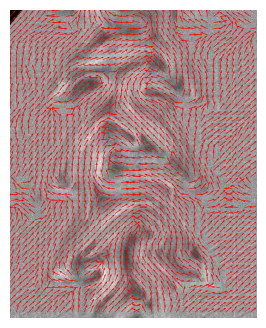

In [170]:
img = io.imread(r"C:\Users\liuzy\Documents\AN\kymo\08_C-2100.tif")
d, s = fndstruct(1, 10, img)
plt.figure(figsize=(4,4), dpi=100)
plt.imshow(img, cmap='gray')
step = 10  # Adjust the step size to make the arrows sparse
Y, X = np.mgrid[0:img.shape[0]:step, 0:img.shape[1]:step]
plt.quiver(X, Y, d[::step, ::step, 0], d[::step, ::step, 1], color='r', scale=30)
plt.axis("off")

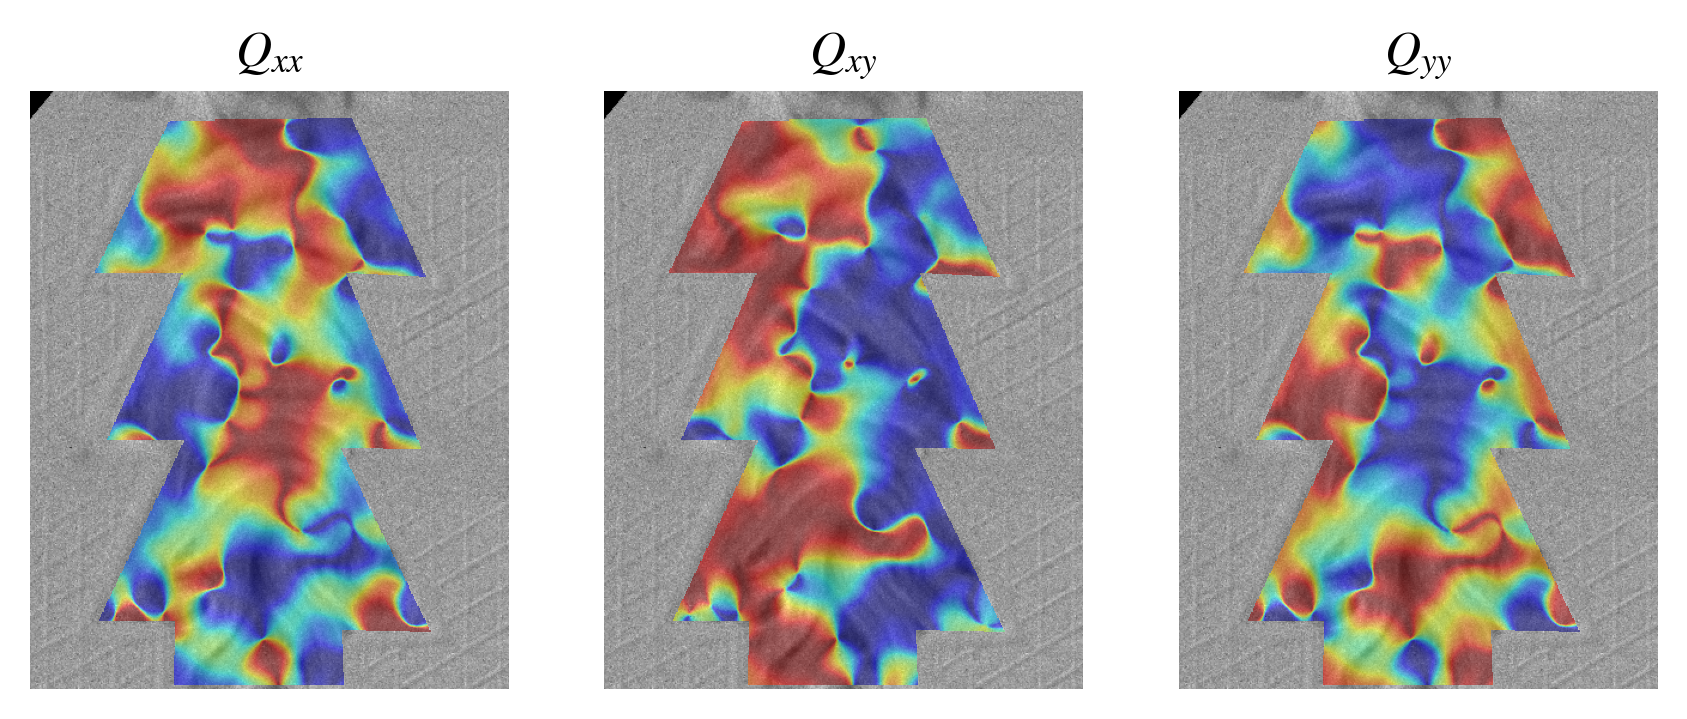

In [164]:
mask = io.imread(r"C:\Users\liuzy\Documents\AN\08 jun 2023\mask\C08.tif")
# compute Q-tensor
Q = qTensor(d, size=3)
Qxx, Qxy, Qyy = Q[:, :, 0, 0], Q[:, :, 0, 1], Q[:, :, 1, 1]
# plot Q-tensor 
fig, ax = plt.subplots(1, 3, figsize=(7, 4), dpi=300)
for i, q in enumerate([Qxx, Qxy, Qyy]):
    ax[i].imshow(img, cmap="gray")
    q[~mask.astype("bool")] = np.nan
    ax[i].imshow(q, cmap='jet', vmin=-0.5, vmax=0.5, alpha=0.5)
    ax[i].set_title(["$Q_{xx}$", "$Q_{xy}$", "$Q_{yy}$"][i])
    ax[i].axis('off')

In these colored fields, smooth color indicates ordered regions, and sharp gradients indicate disordered regions. In a nematic system, highly disordered regions are typically where the topological defects are, and the bending energy associated with these regions are typically high. Therefore, the magnitude of the gradients of Q-tensor is a good way to quantify the bending energy in this system. In the next section, we are going to use this idea to compute bending energy.

### 3.2 Bending energy

Here, We evaluate the bending energy based on the gradients of $Q$ tensor. <font color="red"> I don't find an expression for the bending energy, but intuitively, it should be related to the gradient of all the components of the gradients of the Q-tensor.</font> Here, I choose to express the energy as the sum of all unique Q-tensor gradient components:

$$
e = (\partial_x Q_{xx})^2 + (\partial_y Q_{xx})^2 + (\partial_x Q_{xy})^2 + (\partial_y Q_{xy})^2 + (\partial_x Q_{yy})^2 + (\partial_y Q_{yy})^2.
$$

as there are 3 independent components of Q-tensor and the gradient happens in two dimensions, we have 2x3=6 terms in total. 


In [21]:
def compute_bending_energy(Q_tensor):
    """
    Compute the bending energy from a 2D Q-tensor.

    Args:
    Q_tensor: A 2D array of Q-tensor components with shape (Nx, Ny, 2, 2).

    Returns:
    bending_energy: The total bending energy.
    """

    # Compute spatial derivatives using finite differences
    dQxx_dx = np.gradient(Q_tensor[:, :, 0, 0], axis=0)
    dQxx_dy = np.gradient(Q_tensor[:, :, 0, 0], axis=1)
    dQxy_dx = np.gradient(Q_tensor[:, :, 0, 1], axis=0)
    dQxy_dy = np.gradient(Q_tensor[:, :, 0, 1], axis=1)
    dQyy_dx = np.gradient(Q_tensor[:, :, 1, 1], axis=0)
    dQyy_dy = np.gradient(Q_tensor[:, :, 1, 1], axis=1)

    # Compute the bending energy density
    bending_energy = (
        dQxx_dx**2 + dQxx_dy**2 +
        dQxy_dx**2 + dQxy_dy**2 +
        dQyy_dx**2 + dQyy_dy**2
    )

    return bending_energy

In [165]:
e = compute_bending_energy(Q)

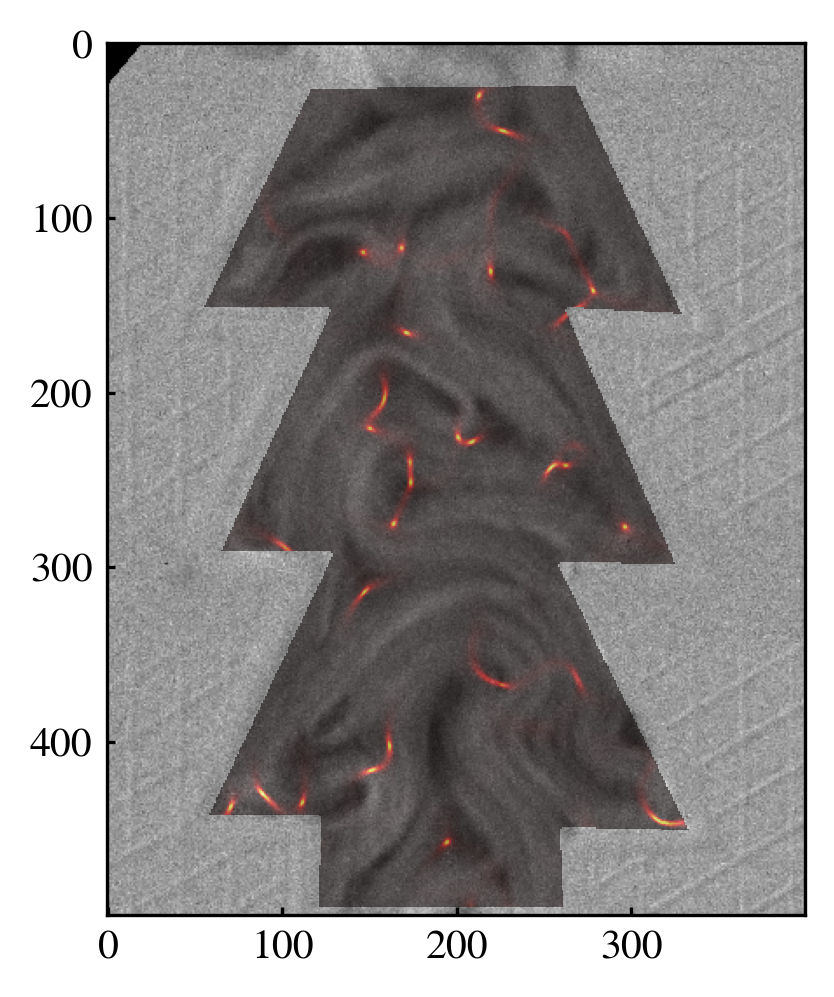

In [166]:
# overlay the image and the bending energy
fig, ax = plt.subplots(figsize=(3, 4), dpi=300)
ax.imshow(img, cmap="gray")
e[~mask.astype("bool")] = np.nan
e = e / np.nanmax(e)
ax.imshow(e, cmap='hot', alpha=0.5, vmin=0, vmax=1)

At the first look, the bending energy are very concentrated: a few spots have very high bending energy, while the rest regions are mostly aligned and do not contribute much to the bending. To be more quantitative, we can look at the energy histogram.  

Text(0, 0.5, 'counts')

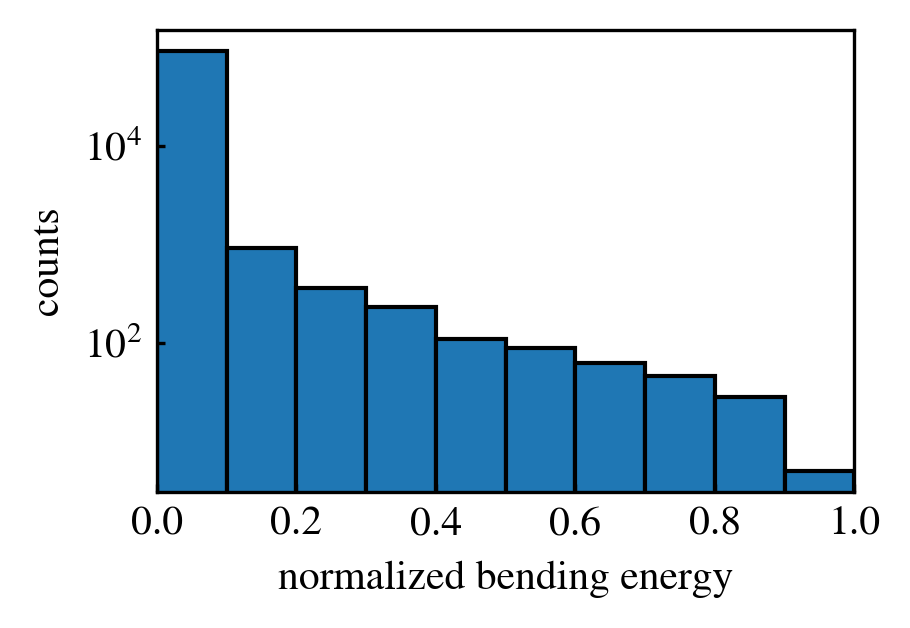

In [167]:
# histogram of e
fig, ax = plt.subplots(figsize=(3, 2), dpi=300)
hist, bins = np.histogram(e[mask.astype("bool")].flatten(), bins=10, range=(0, np.nanmax(e)))
ax.bar(bins[:-1], hist, width=np.diff(bins), edgecolor="black", align="edge")
ax.set_xlim([0, 1])
ax.set_yscale("log")
ax.set_xlabel("normalized bending energy")
ax.set_ylabel("counts")


The energy distribution amongst pixels is not too surprising: the few high energy spots are not dominant if we take an average over all the pixels. So the current treatment of the director field seems OK. 

I'm also interested in the spatial distribution of the energy:
- is energy more concentrated in the middle of the channel, or close to the corners?
- is energy evenly distributed along the channel?

To answer this, we plot the mean energy along both axes. 

C:\Users\liuzy\AppData\Local\Temp\ipykernel_43552\3295942682.py:18: RuntimeWarning: Mean of empty slice
  ax_histx.fill_between(range(w), np.nanmean(e, axis=0), color=bestcolor(0))
C:\Users\liuzy\AppData\Local\Temp\ipykernel_43552\3295942682.py:26: RuntimeWarning: Mean of empty slice
  ax_histy.fill_betweenx(range(h), np.nanmean(e, axis=1), color=bestcolor(0))


(-0.002348246555278384, 0.04931317766084606, 500.0, 0.0)

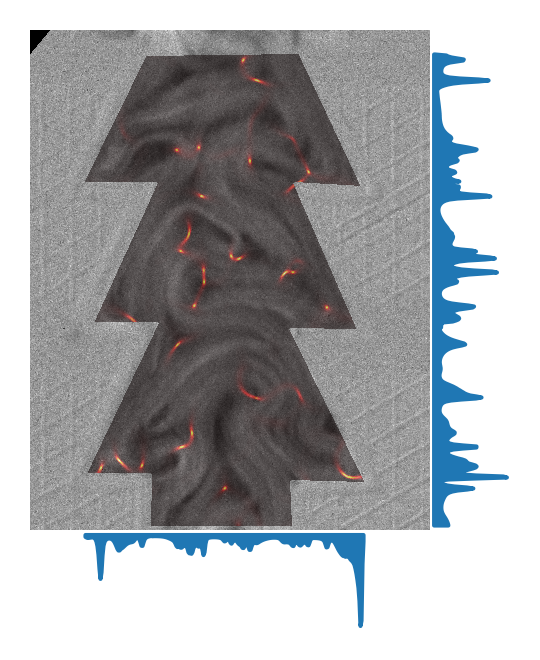

In [169]:
# get image shape
h, w = img.shape
dpi = 300
e[~mask.astype("bool")] = np.nan

# Plot image and histograms
fig = plt.figure(figsize=(w/dpi, h/dpi), dpi=dpi)

# Display the image
ax_image = fig.add_axes([0,0,1,1])
ax_image.imshow(img, cmap='gray')
ax_image.imshow(e, cmap='hot', alpha=0.5, vmin=0, vmax=1)
ax_image.axis("off")

# Display histogram for x-axis
ax_histx = fig.add_axes([0, -0.2, 1 , 0.2])
# ax_histx.plot(range(w), np.nansum(e, axis=0))
ax_histx.fill_between(range(w), np.nanmean(e, axis=0), color=bestcolor(0))
ax_histx.invert_yaxis()
ax_histx.set_xlim([0, w])
ax_histx.axis("off")

# Display histogram for y-axis
ax_histy = fig.add_axes([1, 0, .2, 1])
# ax_histy.plot(np.nansum(e, axis=1), range(h))
ax_histy.fill_betweenx(range(h), np.nanmean(e, axis=1), color=bestcolor(0))
ax_histy.invert_yaxis()
ax_histy.set_ylim([h, 0])
ax_histy.axis("off")

According to the horizontal and vertical energy distribution, we can see that most bending happens near the ratchet tips at the boundaries. The main channel also has some bending, but at a smaller amplitude.

### 3.3 Q-tensor Smoothing

I notice that smoothing the Q-tensor can influence the look of the energy map. Does it also influence the mean bending energy? In this section, we test it on one image. 

In [174]:
### params ###
img = io.imread(r"C:\Users\liuzy\Documents\AN\kymo\08_C-2100.tif")
sigma1 = 1
sigma2 = 8
smooth_size = range(0,35,2)
##############
d, s = fndstruct(sigma1, sigma2, img)
e_list = []
for size in smooth_size:

    Q = qTensor(d, size=size)
    e = compute_bending_energy(Q)
    e_list.append(np.nanmean(e))

Text(0, 0.5, 'bending energy')

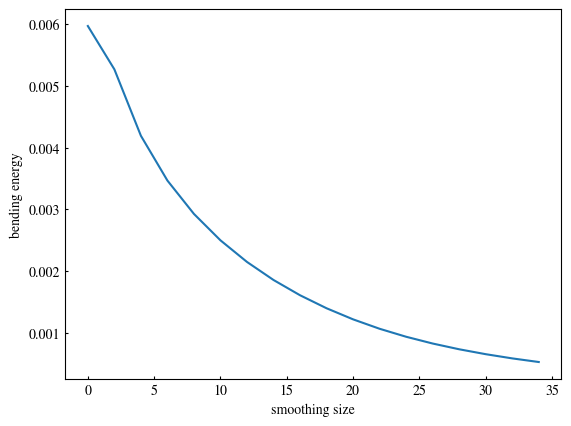

In [176]:
plt.plot(smooth_size, e_list)
plt.xlabel("smoothing size")
plt.ylabel("bending energy")

I could not find a "special" smooth kernel size. The mean bending energy seems to smoothly decay with smoothing size. To make the treatment more rigorous and reproducilbe, I shall use the Q-tensor smoothing size the same as the `sigma2` for structure tensor. 

## 4 Convert director to angle

Saving director requires [M x N x F x 2] matrix of floats, which can take up a lot of storage space (8 times of the images). To reduce it, we convert the director field to angle field and use a 8-bit number to represent the angle, i.e. angle8 = angle/pi*255, where angle is in [0, pi). 

In [178]:
def director_to_angle(director_field):
    """
    Convert a director field to an angle field.

    Args:
    director_field -- the input director field, [M x N x 2].

    Returns:
    angle_field -- the angle field, [M x N].
    """
    angle_field = np.arctan(director_field[:, :, 1] / director_field[:, :, 0]) + np.pi/2
    angle_field_8bit = (angle_field / np.pi * 255).astype(np.uint8)
    return angle_field_8bit

(-0.5, 399.5, 499.5, -0.5)

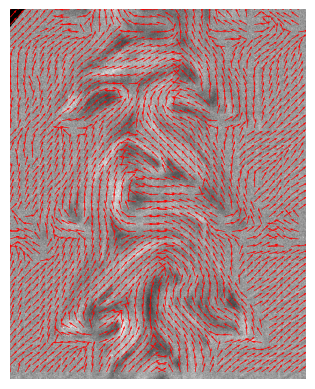

In [186]:
# compute director field
img = io.imread(r"C:\Users\liuzy\Documents\AN\kymo\08_C-2100.tif")
d, s = fndstruct(1, 10, img)

# plot
plt.imshow(img, cmap='gray')
step = 10  # Adjust the step size to make the arrows sparse
Y, X = np.mgrid[0:img.shape[0]:step, 0:img.shape[1]:step]
plt.quiver(X, Y, d[::step, ::step, 0], d[::step, ::step, 1], color='r', scale=30)
plt.axis("off")

In [187]:
# convert to 8-bit angle
angle = director_to_angle(d)
angle.shape

(500, 400)

Then, I write a function to recover the director field from the 8-bit angle field.

In [182]:
def angle_to_director(angle_8_bit):
    """
    Convert an 8-bit angle image to a director field.

    Args:
    angle_8_bit -- the input 8-bit angle image, [M x N].

    Returns:
    director -- the output director field, [M x N x 2].
    """
    angle = angle_8_bit / 255 * np.pi - np.pi / 2
    director = np.array([np.cos(angle), np.sin(angle)]).transpose(1, 2, 0)

    return director

In [184]:
# reconstruct the director field
d = angle_to_director(angle)
# plot
plt.imshow(img, cmap='gray')
step = 10  # Adjust the step size to make the arrows sparse
Y, X = np.mgrid[0:img.shape[0]:step, 0:img.shape[1]:step]
plt.quiver(X, Y, d[::step, ::step, 0], d[::step, ::step, 1], color='r', scale=30)
plt.axis("off")

I do this in the hope that I can save the preprocessed director field as 8-bit angles to save storage space. The idea is that in this process, computing the structure tensor and eigens takes the most of the time. I hereby test the speed of 

1. Computing Q-tensor directly from the image
2. Computing Q-tensor from 8-bit angle field

In [ ]:
img = io.imread(r"C:\Users\liuzy\Documents\AN\kymo\08_C-2100.tif")

In [200]:
# from image
for i in range(20):
    d, s = fndstruct(1, 10, img)
    Q = qTensor(d, size=10)

In [197]:
# prep angle field
angle = director_to_angle(d)

In [201]:
# from angle field
for i in range(20):
    d = angle_to_director(angle)
    Q = qTensor(d, size=10)

In the above, I tested computing Q-tensor from image directly, as well as computing from the angle field. The result is that: **computing from angle field is 30 times faster than from image**, suggesting that processing the raw image takes the majority of time, and saving the director field as angles can greatly save the time for the following processing. On the other hand, saving the Q-tensor in files can take a lot more storage space (4x16-bit per pixel), while not allowing the director field to be loaded and plotted.

From now on, I will save the angle 8-bit field as the intermediate result for the bending analysis. Q-tensor is not longer saved as files, but is only computed when bending energy needs to be computed. 

## 5 Plot bending energy with flow rate


### 5.1 Time series

In [ ]:
# symmetric channels
folder = r"G:\My Drive\NASync\Sample 1\nd2"
fps = 2
be = {"A": [], "B": [], "C": []}
offset = {"A": 0, "B": 0, "C": 0}
file_range = range(6, 12)
for i in file_range:
    for channel in ["A", "B", "C"]:
        e = pd.read_csv(os.path.join(folder, "bending_energy", f"{i:02d}_{channel}.csv"))[:-1]
        e["frame"] += offset[channel]
        be[channel].append(e)
        offset[channel] = e["frame"].max()
for channel in ["A", "B", "C"]:
    be[channel] = pd.concat(be[channel])
    be[channel]["bending_energy"] *= 1000

In [ ]:
flowrate = []
offset = 0
for i in file_range:
    fr = pd.read_csv(os.path.join(folder, "Flow_rate", f"{i:02d}.csv")).dropna()
    fr["t"] += offset
    flowrate.append(fr)
    offset = fr["t"].max()
flowrate = pd.concat(flowrate)
flowrate["normalizer"] = gaussian_filter1d(flowrate[["A", "B", "C"]].abs().max(axis=1), sigma=window_size, axis=0)

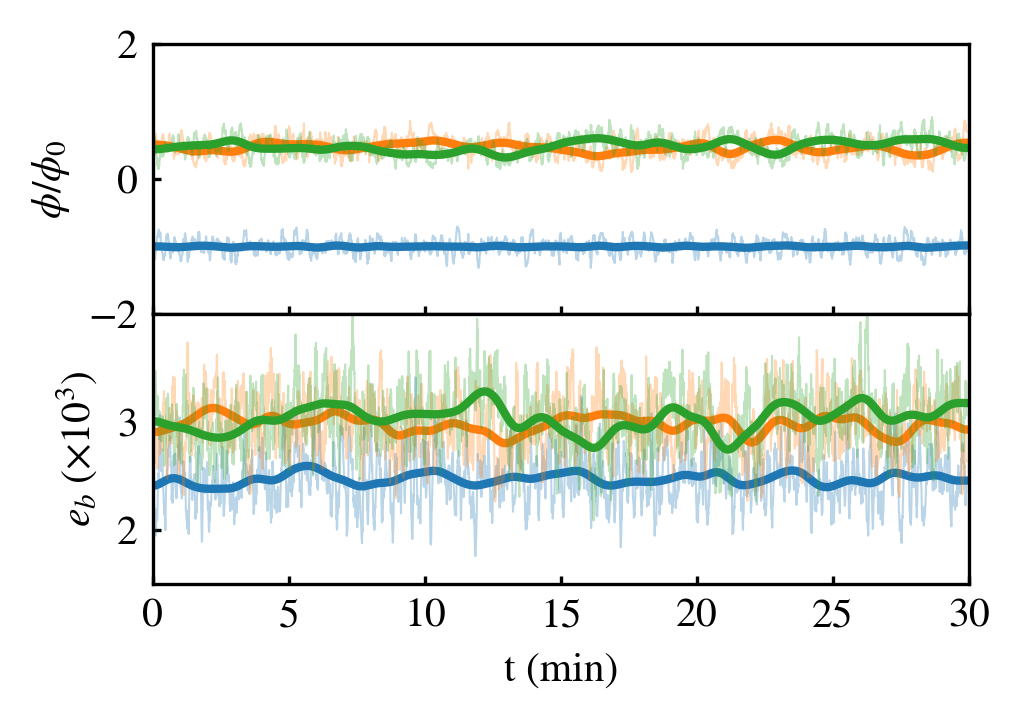

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(3.5,2.5), dpi=300, sharex=True, gridspec_kw={"hspace": 0})
for num, channel in enumerate(["A", "B", "C"]):
    ax[0].plot(flowrate.t/60, flowrate[channel]/flowrate["normalizer"], label=channel, lw=.5, alpha=0.3, color=bestcolor(num))
    ax[0].plot(flowrate.t/60, gaussian_filter1d(flowrate[channel]/flowrate["normalizer"], window_size), label=channel, lw=2, alpha=1, color=bestcolor(num))
    ax[1].plot(be[channel]["frame"]/fps/60, be[channel]["bending_energy"], label=channel, lw=.5, alpha=0.3, color=bestcolor(num))
    ax[1].plot(be[channel]["frame"]/fps/60, gaussian_filter(be[channel]["bending_energy"],  window_size), label=channel, lw=2, alpha=1, color=bestcolor(num))
ax[0].set_xlim([0, 30])
ax[0].set_ylim([-2, 2])
ax[1].set_ylim([1.5, 4])
ax[1].set_yticks([2, 3])
ax[0].set_ylabel("$\phi/\phi_0$")
ax[1].set_ylabel("$e_b \;(\\times 10^3)$")
ax[1].set_xlabel("t (min)")
plt.tight_layout()
fig.savefig("flowrate_bending.pdf")

### 5.2 Scaling relation

I have an argument that the energy penalty is proportional to the square of the flow rate difference from the preferred flow rate $\phi_0$. Here, we can plot the bending energy at all time as a function of flow rate to see the relation. 

I had the assumption that the bending energy is proportional to the square of the difference between flow rate and the preferred flow rate, that is:

$$
E_p \propto (\phi - \phi_0)^2 L.
$$

However, when measuring the bending energy experimentally, I realize that even when $\phi=\phi_0$, $E_p$ is nonzero. So a better model would be 

$$
E_{total} = E_0 + E_p,
$$

where $E_0$ is a constant when $\phi=\phi_0$, and $E_p$ depends on the flow rate. 

Here, we use the mean flow rate in channel A as the $\phi_0$. The mean bending energy in channel A is thus $E_0$. We plot $E_p$ as a function of $\phi-\phi_0$ to see the scaling relation. 

Text(0, 0.5, 'excess energy density, $e_p$')

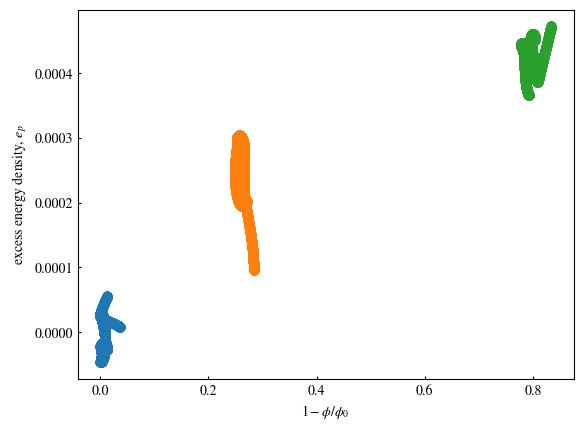

In [13]:
sigma = 300
phi0 = flowrate["A"].abs().mean()
f0 = bending_energy["A"]["bending_energy"].mean()
# plot channel A
fp = gaussian_filter(bending_energy["A"]["bending_energy"], sigma) - f0
dphi = np.abs(np.abs(gaussian_filter(flowrate["A"], sigma)) - phi0) / phi0
plt.plot(dphi, fp, 'o', color=bestcolor(0))
# plot channel B
fp = gaussian_filter(bending_energy["B"]["bending_energy"], sigma) - f0
dphi = np.abs(gaussian_filter(flowrate["B"], sigma) - phi0) / phi0
plt.plot(dphi, fp, 'o', color=bestcolor(1))
fp = gaussian_filter(bending_energy["C"]["bending_energy"], sigma) - f0
dphi = np.abs(gaussian_filter(flowrate["C"], sigma) - phi0) / phi0
plt.plot(dphi, fp, 'o', color=bestcolor(2))
# plt.loglog()
# x = np.linspace(600, 1500)
# y = x ** 2 / 3e8
# plt.plot(x, y)
# plt.xlim([0, 2000])
# plt.ylim([0, 0.01])
plt.xlabel("$1-\phi/\phi_0$")
plt.ylabel("excess energy density, $e_p$")

Text(0, 0.5, 'excess energy density, $e_p$')

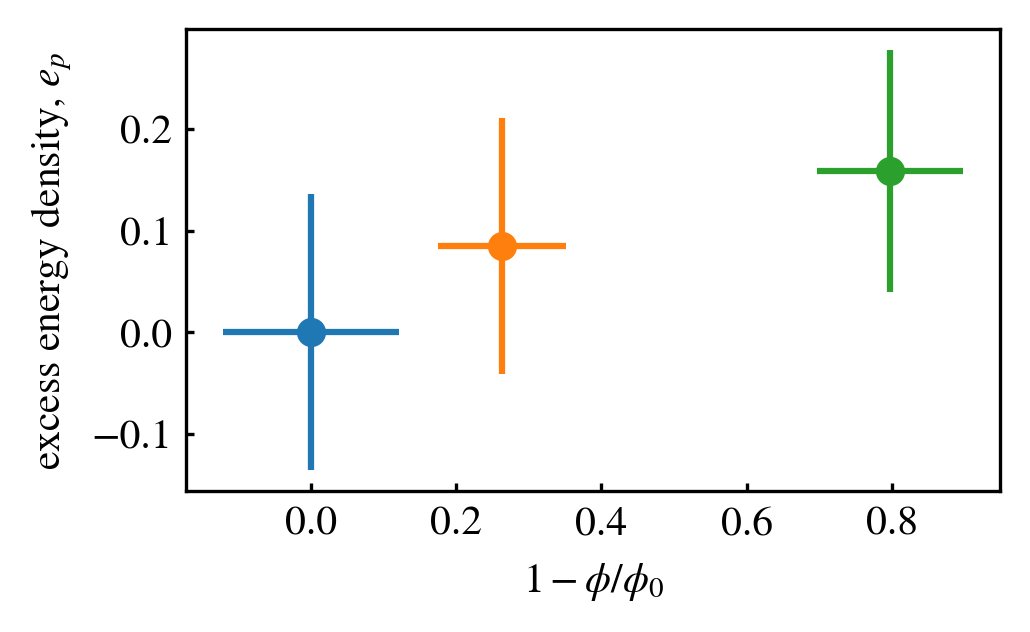

In [14]:
fig, ax = plt.subplots(figsize=(3.5, 2), dpi=300)
phi0 = flowrate["A"].abs().mean()
f0 = bending_energy["A"]["bending_energy"].mean()
for channel in ["A", "B", "C"]:
    dphi_mean = ((phi0 - np.abs(flowrate[channel])) / phi0).mean()
    dphi_std = (np.abs(flowrate[channel] - phi0) / phi0).std()
    ep_mean = (bending_energy[channel]["bending_energy"].mean() - f0) / f0
    ep_std = bending_energy[channel]["bending_energy"].std() / f0
    ax.errorbar(dphi_mean, ep_mean, xerr=dphi_std, yerr=ep_std, fmt='o', color=bestcolor(["A", "B", "C"].index(channel)))
# plt.loglog()
ax.set_xlabel("$1-\phi/\phi_0$")
ax.set_ylabel("excess energy density, $e_p$")
# ax.set_xlim([0.1, 1])
# ax.set_ylim([0, 0.01])

# Appendix 

## A. Verify director field

In [84]:
img = io.imread(r"C:\Users\liuzy\Documents\AN\08 jun 2023\crop_channel\08_A.tif")[0]
angle = np.load(r"C:\Users\liuzy\Documents\AN\08 jun 2023\director_field\08_A.npy")[0]
mask = io.imread(r"C:\Users\liuzy\Documents\AN\08 jun 2023\mask\A08.tif")

(-0.5, 399.5, 499.5, -0.5)

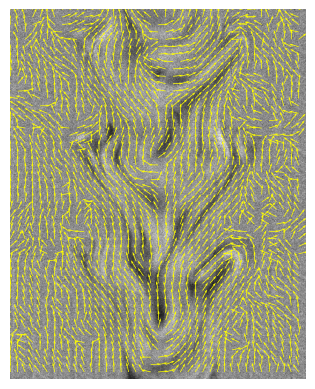

In [88]:
plt.imshow(img, cmap='gray')
step = 10  # Adjust the step size to make the arrows sparse
Y, X = np.mgrid[0:img.shape[0]:step, 0:img.shape[1]:step]
d = angle_to_director(angle)
plt.quiver(X, Y, d[::step, ::step, 0], d[::step, ::step, 1], scale=30, color="yellow")
plt.axis("off")

## B. Compare sequence filter and 2D-convolution filter

When reading the documents of `scipy.ndimage.gaussian_filter`, I notice that the 2D gaussian is implemented as a sequence of two 1D gaussians. Would this be very different from applying a 2D convolution directly?

To answer this question, we rewrite the `fndstruct` function using 2D convolution and compare the director result with the original function.

In [85]:
def fndstruct_conv(sigma1, sigma2, im):
    """
    Returns the structure tensor orientation of an image. Smooth with convolution.

    Args:
    sigma1 -- gaussian filter sigma for the raw image.
    sigma2 -- gaussian filter sigma for the gradient fields.
    im -- the input image, [M x N].

    Returns:
    director -- the director field of the nematic system, [M x N x 2].
    S -- the magnitude of the Q-tensor, [M x N].
    """
    imgf = gaussian_conv(im, sigma1, 4*sigma1)

    gx, gy = np.gradient(imgf)

    gxgx = gx * gx
    gxgy = gx * gy
    gygy = gy * gy

    gxgx = gaussian_conv(gxgx, sigma2, 4*sigma2)
    gxgy = gaussian_conv(gxgy, sigma2, 4*sigma2)
    gygy = gaussian_conv(gygy, sigma2, 4*sigma2)

    aa = np.array([[gxgx, gxgy], [gxgy, gygy]])
    eigenvalues, eigenvectors = np.linalg.eig(aa.transpose(2, 3, 0, 1).reshape(-1, 2, 2))
    eigenvalues = eigenvalues.reshape(aa.shape[2], aa.shape[3], 2)
    eigenvectors = eigenvectors.reshape(aa.shape[2], aa.shape[3], 2, 2)

    # Find the indices of the smaller eigenvalues
    indices = np.argmax(eigenvalues, axis=2)

    # Extract the corresponding eigenvectors
    director = np.array([eigenvectors[i, j, :, indices[i, j]] for i in range(eigenvectors.shape[0]) for j in range(eigenvectors.shape[1])])
    director = director.reshape(eigenvectors.shape[0], eigenvectors.shape[1], 2)

    # require the y component director to be positive, otherwise flip the director
    director[director[:,:,1]<=0] *= -1

    return director, np.max(eigenvalues, axis=2)

In [90]:
from scipy.signal import fftconvolve

def gaussian_conv(arr, sigma, radius):
    """
    Convolve the array with a 2D Gaussian kernel.

    Args:
    arr -- the input array.
    sigma -- the standard deviation of the Gaussian kernel.
    radius -- the radius of the kernel.

    Returns:
    arr_conv -- the convolved array.
    """
    kernel = generate_gaussian_kernel(radius, sigma)
    arr_conv = fftconvolve(arr, kernel, mode='same')
    return arr_conv

In [62]:
def generate_gaussian_kernel(radius, sigma):
    """
    Generates a 2D Gaussian kernel using scipy.ndimage.gaussian_filter.

    Parameters:
    radius (int): The radius of the kernel.
    sigma (float): The standard deviation of the Gaussian distribution.

    Returns:
    numpy.ndarray: A 2D Gaussian kernel.
    """
    # Calculate the size from the radius
    size = 2 * radius + 1

    # Create an array with a single one in the middle
    kernel = np.zeros((size, size))
    kernel[radius, radius] = 1

    # Apply Gaussian filter to create the kernel
    gaussian_kernel = gaussian_filter(kernel, sigma=sigma)

    return gaussian_kernel

Text(0.5, 1.0, 'gaussian_conv')

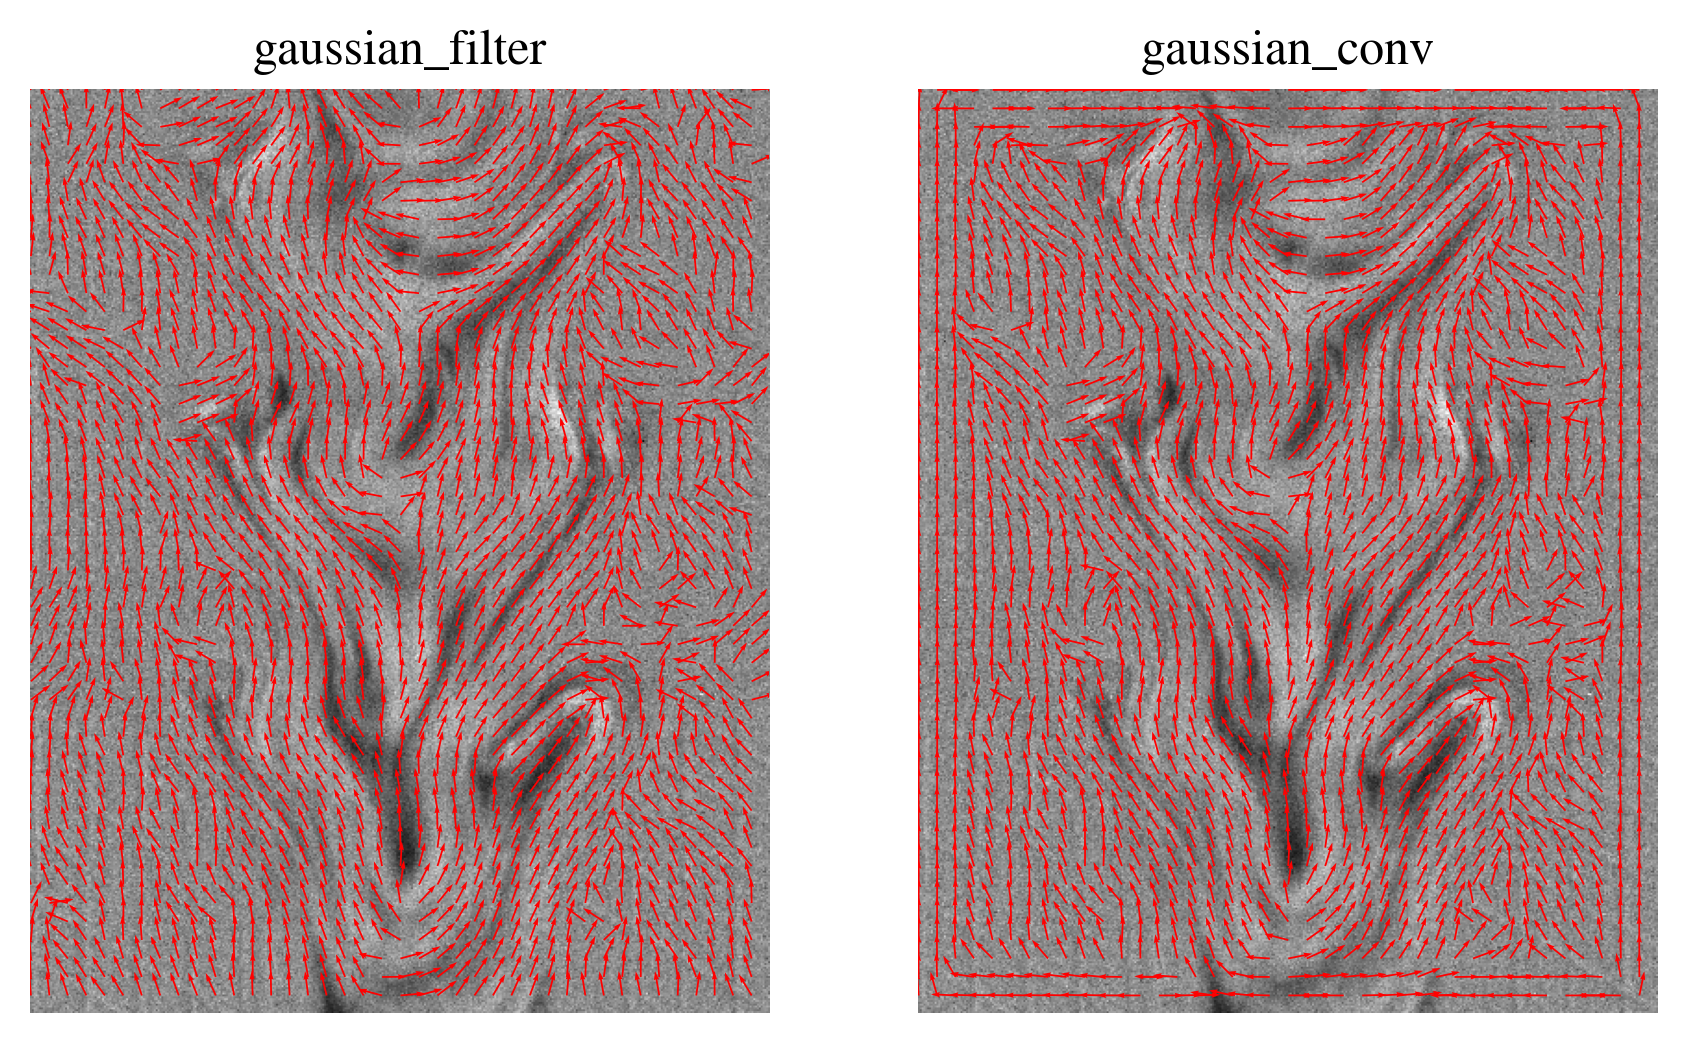

In [97]:
# test image
img = io.imread(r"C:\Users\liuzy\Documents\AN\kymo\08_A-2100.tif")
# compute the director field
d_conv, s_conv = fndstruct_conv(1, 10, img)
d, s = fndstruct(1, 10, img)
# prepare the quiver plot
step = 10  # Adjust the step size to make the arrows sparse
Y, X = np.mgrid[0:img.shape[0]:step, 0:img.shape[1]:step]
# plot the results
fig, ax = plt.subplots(1, 2, figsize=(7,4), dpi=300)
ax[0].imshow(img, cmap='gray')
ax[0].quiver(X, Y, d[::step, ::step, 0], d[::step, ::step, 1], color='r', scale=30)
ax[0].axis('off')
ax[0].set_title("gaussian_filter")
ax[1].imshow(img, cmap='gray')
ax[1].quiver(X, Y, d_conv[::step, ::step, 0], d_conv[::step, ::step, 1], color='r', scale=30)
ax[1].axis('off')
ax[1].set_title("gaussian_conv")

**Conclusion**

the sequence of 1D filter `scipy.ndimage.gaussian_filter` gives smoother and visually more accurate director field than the convolution. It's worth noting that it's also faster, even after optimizing the convolution with FFT. Therefore, I'm going to continue using `scipy.ndimage.gaussian_filter`.

## C. Q-tensor in Perry Ellis' code

One thing I don't understand about his code is that: he constructs a tensor $D$ in a way that resembles the Q-tensor

$$
D = \begin{bmatrix}
n_xn_x & n_xn_y - 0.5 \\ 
n_xn_y - 0.5 & n_yn_y 
\end{bmatrix}
$$

Then, he computes the eigenvalues and eigenvectors of $D$, and used the results as the final Q-tensor component.

Here, I use some arbitrary $n$ to test.

In [202]:
n = np.random.rand(2)
n /= np.linalg.norm(n)

In [203]:
D = np.outer(n, n) - 0.5 * np.eye(2)

In [204]:
evals, evecs = np.linalg.eig(D)

In [205]:
D

array([[ 0.26443256,  0.42435295],
       [ 0.42435295, -0.26443256]])

In [206]:
evals

array([ 0.5, -0.5])

In [207]:
evecs

array([[ 0.87431834, -0.48535291],
       [ 0.48535291,  0.87431834]])

In [212]:
n

array([0.87431834, 0.48535291])

**Conclusion**

We can see that the eigenvector of the Q-tensor is essentially the director vector $n$, maybe rescaled to unity. Therefore, I conclude that computing the eigenvalue of Q-tensor is a redundant step. To get director, we can just construct the structure tensor and compute eigenvectors.